In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import seaborn as sns
from scipy.stats import pearsonr
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes (for inset plots)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset (for inset plots)
from xarrayutils.utils import linear_trend, xr_linregress
from eofs.xarray import Eof

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne        #TODO: Split polygons for Ronne1, Ronne2 etc.
# 104 : Western Ross #TODO: Split polygons for W-Ross1, W-Ross2 etc.
# 105 : Eastern Ross #TODO: Split polygons for E-Ross1, E-Ross2 etc.
# 114 : Thwaites

basin = 34
basinName = icems.name.values[basin]

In [6]:
# Mask data to chosen basin
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [7]:
dsn = ds.dropna('y',how='all')
dsn = dsn.dropna('x',how='all')
dsn = dsn.dropna('time',how='all')

In [9]:
flx = dsn.timeMonthly_avg_landIceFreshwaterFlux
h = dsn.timeMonthly_avg_ssh

In [10]:
flx_tmean = flx.mean('time')

In [11]:
flx_mean = flx.mean()

In [77]:
eps = flx - flx_mean

In [78]:
eps_tmean = eps.mean('time')

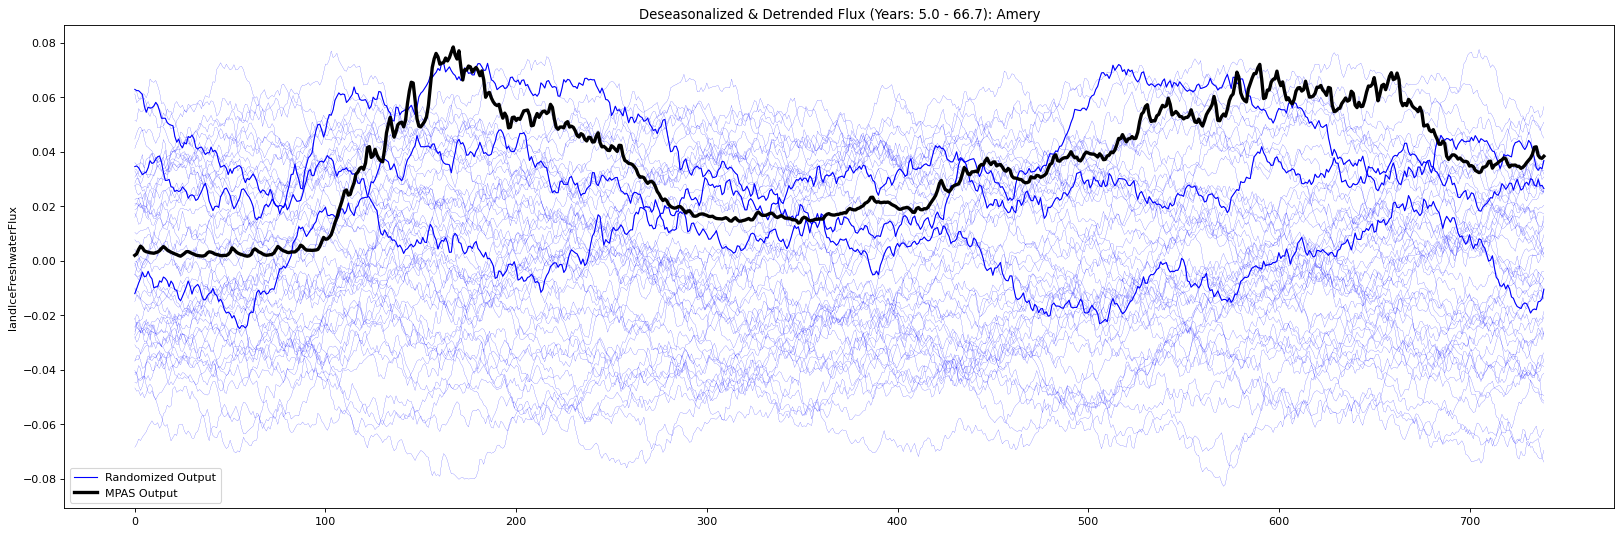

In [61]:
# Plot phase randomized data
plt.figure(figsize=(25, 8), dpi=80)

spinuptime = 0 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx.mean(['x','y'])[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 800

for i in range(n_realizations):    
    fl = flx.sum(['x','y'])[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized & Detrended Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [62]:
orig_ts = fl

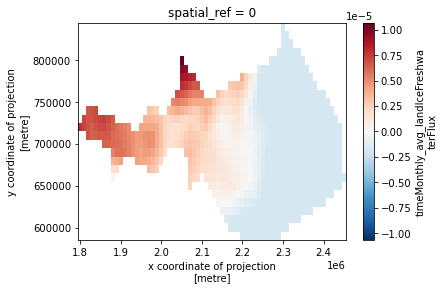

In [101]:
flx_orig_reconstr = eps*(orig_ts+flx_mean)
flx_orig_reconstr.mean('time').plot()

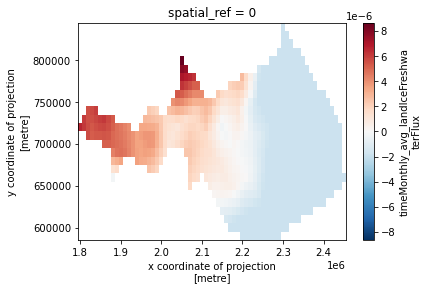

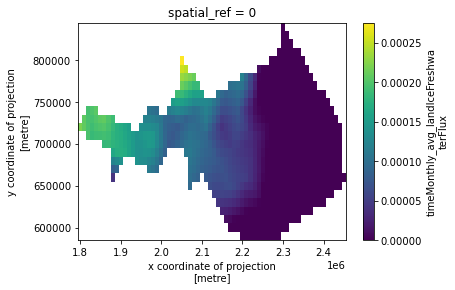

In [93]:
flx.mean('time').plot()

(array([9.84354e+05, 2.27313e+05, 1.21998e+05, 6.16070e+04, 1.82220e+04,
        3.33300e+03, 1.06200e+03, 3.91000e+02, 1.04000e+02, 1.60000e+01]),
 array([-3.41063092e-06,  6.16932378e-05,  1.26797106e-04,  1.91900975e-04,
         2.57004844e-04,  3.22108713e-04,  3.87212581e-04,  4.52316450e-04,
         5.17420319e-04,  5.82524187e-04,  6.47628056e-04]),
 <BarContainer object of 10 artists>)

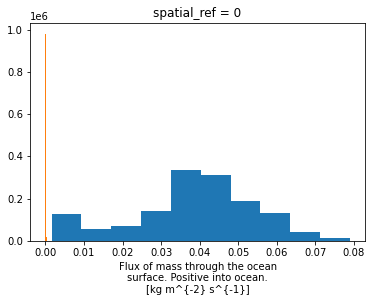

In [68]:
flx_orig_reconstr.plot()
flx.plot()